# M&M analysis on FMO2 data in GTEx

This vignette shows multi-tissue fine mapping using the "Sum of Single Effects" (SuSIE) approach. 

## Implementation of prototype

This version implements a modular version that relies heavily on `mashr`. In order to keep track of various quantities of interest and try multiple alternatives, the prototype is done as a DSC problem in `src/model_dsc`.

In [1]:
%cd ../src/model_dsc

/home/gaow/GIT/github/mvarbvs/src/model_dsc

In [2]:
./model.dsc -h


INFO: MODULES
+------------+---------------------+--------------------------------+-------------------+------+
|            |      parameters     |             input              |       output      | type |
+------------+---------------------+--------------------------------+-------------------+------+
|  get_data  |      data_file      |                                |        data       |  R   |
| original_Y |                     |              data              |        data       |  PY  |
| init_model | Sigma, (U, grid, p) |              data              |    data, model    |  R   |
|    fit     |      maxL, maxI     |          data, model           | fitted, posterior |  R   |
|  diagnose  |                     | data, model, fitted, posterior |     diagnosed     |  R   |
+------------+---------------------+--------------------------------+-------------------+------+

INFO: PIPELINES
first_pass: get_data -> get_Y -> init_model -> fit -> diagnose

INFO: PIPELINES EXPANDED
1: get

For the time being:

- `get_data` load gene specific data from GTEx
- `get_Y` either simulate expression data `Y`, or use the original
- `init_model` perform preliminary `mash` analysis to obtain the mixture prior
- `fit` fit the m&m model: `maxL` is max number of single effects, `maxI` is number of iterations
- `diagnose` compute ELBO etc

As a first pass I extracted data for FMO2 on Thyroid and Lung. I use a maximum of 5 effects and 10 iterations of variational updates:

In [3]:
./model.dsc

INFO: DSC script exported to mnm_model.html
INFO: Constructing DSC from ./model.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|████████████████████████████████████████| 6/6 [04:07<00:00, 33.19s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 249.601 seconds.


Scripts for the DSC can be found [here](20180415_mnm_model.html). **Specifically look at the `fit` module for m&m core computations.**

## Plot fine-mapping results

In [4]:
res = readRDS('mnm_model/fit/get_data_1_original_Y_1_init_model_1_fit_1.rds')

In [10]:
dat = readRDS('mnm_model/init_model/get_data_1_original_Y_1_init_model_1.rds')
r2 = dat$data$r2

We focus on inferred posterior mean. We plot this quantity in both Thyroid and Lung tissues, annotated by local false sign rate (lfsr) and LD structure.

In [11]:
post_mean = res$posterior$PosteriorMean
post_cov = res$posterior$PosteriorCov
lfsr = res$posterior$lfsr
lfdr = res$posterior$lfdr

In [12]:
%get post_mean post_cov lfsr lfdr r2 --from R

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_beta(yaxis, zaxis, ld, conf):
    xaxis = [x+1 for x in range(len(yaxis))]
    cmap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
    f, ax = plt.subplots(figsize=(18,5))
    points = ax.scatter(xaxis, yaxis, c=zaxis, cmap=cmap)
    f.colorbar(points, label=conf['zlabel'])
    if 'pip_cutoff' in conf:
        for idx, item in enumerate(zaxis):
            if item > conf['pip_cutoff']:
                ax.scatter(xaxis[idx], yaxis[idx], s=80, 
                           facecolors='none', edgecolors='r')
                for ii, xx in enumerate(ld[idx,:]):
                    if xx > conf['ld_cutoff'] and xx < 1.0:
                        ax.scatter(xaxis[ii], yaxis[ii], 
                                   color='y', marker='+')                        
    ax.set_title(conf['title'])
    ax.set_ylabel(conf['ylabel'])
    plt.gca()
    plt.show()

### Thyroid results

Top signals ($lfsr < 0.05$) are circled in red, with SNPs in LD with it ($r^2>0.1$) colored in yellow. 

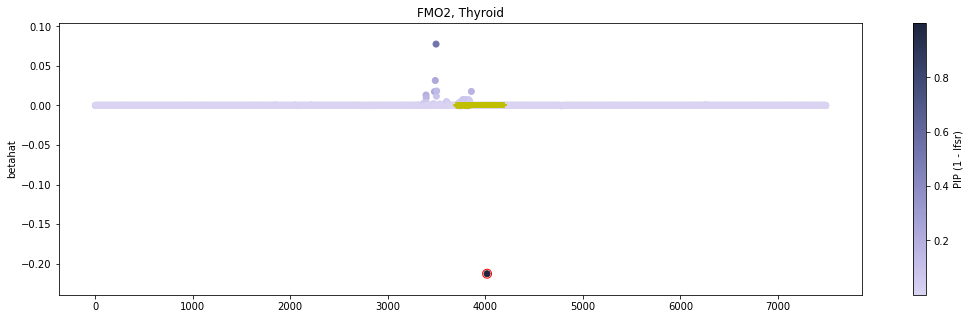

In [20]:
conf = {'title': 'FMO2, Thyroid', 
        'ylabel': 'betahat', 
        'zlabel': 'PIP (1 - lfsr)',
        'pip_cutoff': 0.95,
        'ld_cutoff': 0.1}
plot_beta(post_mean[:,0], 1 - lfsr[:,0], r2, conf)

### Lung results

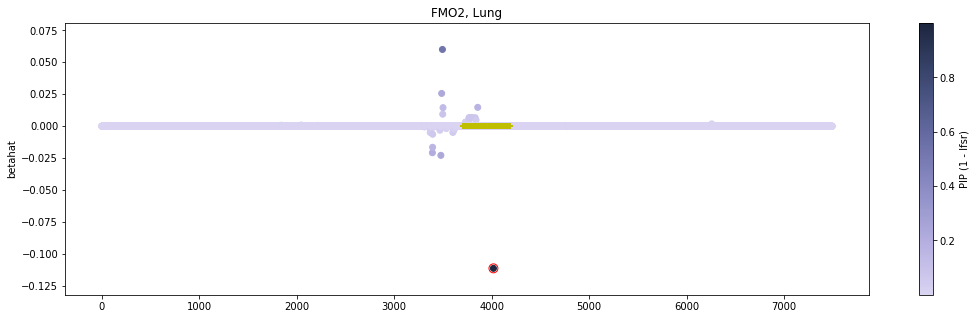

In [21]:
conf = {'title': 'FMO2, Lung', 
        'ylabel': 'betahat', 
        'zlabel': 'PIP (1 - lfsr)',
        'pip_cutoff': 0.95,
        'ld_cutoff': 0.1}
plot_beta(post_mean[:,1], 1 - lfsr[:,1], r2, conf)